In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
from scipy.signal import argrelextrema

sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()

horizons = [2,5,60,250,1000]

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Past_Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    
# Define the number of days for Stochastic Oscillator calculation
osc_n = 14

# Calculate Stochastic Oscillator for each day
sto_osc_values = []
rsi_values = []
for i in range(len(sp500)):
    if i < osc_n - 1:
        sto_osc_values.append(None)  # Placeholder for the initial days where there's not enough data
        rsi_values.append(None)
    else:
        # Calculate Stochastic Oscillator using data from the past 14 days including the current day
        min_price = sp500["Low"].iloc[i - osc_n + 1:i + 1].min()
        max_price = sp500["High"].iloc[i - osc_n + 1:i + 1].max()
        current_close = sp500["Close"].iloc[i]
        sto_osc = ((current_close - min_price) / (max_price - min_price)) * 100
        sto_osc_values.append(sto_osc)

        # RSI
        # Calculate average gain and average loss over the past osc_n days
        gains = [(sp500["Close"].iloc[j] - sp500["Close"].iloc[j - 1]) for j in range(i - osc_n + 1, i + 1) if sp500["Close"].iloc[j] > sp500["Close"].iloc[j - 1]]
        losses = [-(sp500["Close"].iloc[j] - sp500["Close"].iloc[j - 1]) for j in range(i - osc_n + 1, i + 1) if sp500["Close"].iloc[j] < sp500["Close"].iloc[j - 1]]
        
        # Calculate average gain and average loss considering only positive gains and losses
        avg_gain = sum(gains) / osc_n if gains else 0
        avg_loss = sum(losses) / osc_n if losses else 0
        
        # Calculate relative strength (RS)
        rs = avg_gain / avg_loss if avg_loss != 0 else float("inf")
        
        # Calculate RSI
        rsi = 100 - (100 / (1 + rs))
        rsi_values.append(rsi)

# Add Stochastic Oscillator values to DataFrame as a new column
sp500["Stochastic Oscillator"] = sto_osc_values
# Add RSI values to DataFrame as a new column
sp500["RSI"] = rsi_values

def fill_nan_with_distance_to_next_zero(series):
    flag = False
    filled_series = series.copy()
    distance_to_next_zero = 0
    for i in range(len(series)-1, -1, -1):
        if not flag:
            if series[i] == 0:
                flag = True
        else:
            if pd.isna(series[i]):
                distance_to_next_zero += 1
                filled_series[i] = distance_to_next_zero
            else:
                distance_to_next_zero = 0
    return filled_series

# Identifying Trends
order_parameters = [2, 7, 12]

for order in order_parameters:
    # Find local minima and maxima
    minima_indices = argrelextrema(sp500['Close'].values, np.less, order=order)[0]
    maxima_indices = argrelextrema(sp500['Close'].values, np.greater, order=order)[0]

    # Reset index
    sp500_copy = sp500.reset_index()

    # Create a new column for the current order parameter
    trend_column_name = f'Trend_Reversal_{order * 2 + 1}'
    sp500_copy[trend_column_name] = np.nan

    # Assign trend values based on local minima and maxima
    sp500_copy.loc[minima_indices, trend_column_name] = 0  # Downward trend
    sp500_copy.loc[maxima_indices, trend_column_name] = 0  # Upward trend

    sp500_copy[trend_column_name] = fill_nan_with_distance_to_next_zero(sp500_copy[trend_column_name])

    # Set index back to original
    sp500_copy.set_index('Date', inplace=True)
    sp500[trend_column_name] = sp500_copy[trend_column_name]

# Fill NaN values with the previous valid value (i.e., forward fill)
#sp500 = sp500.ffill()

# Adding News Sentiments
file_path = '~/OneDrive/Documents/Northeastern/CS 5100/CS5100 Final Project/data/sentiments/general_scores.csv'
df = pd.read_csv(file_path)
del df['Avg_Polarity']
del df['Avg_Subjectivity']

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

sp500_copy = sp500.copy()
sp500_copy.reset_index(inplace=True)
sp500_copy['Date'] = sp500_copy['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
merged_data = pd.merge(sp500_copy, df, on='Date', how='outer')
merged_data.set_index('Date', inplace=True)
merged_data = merged_data.dropna()

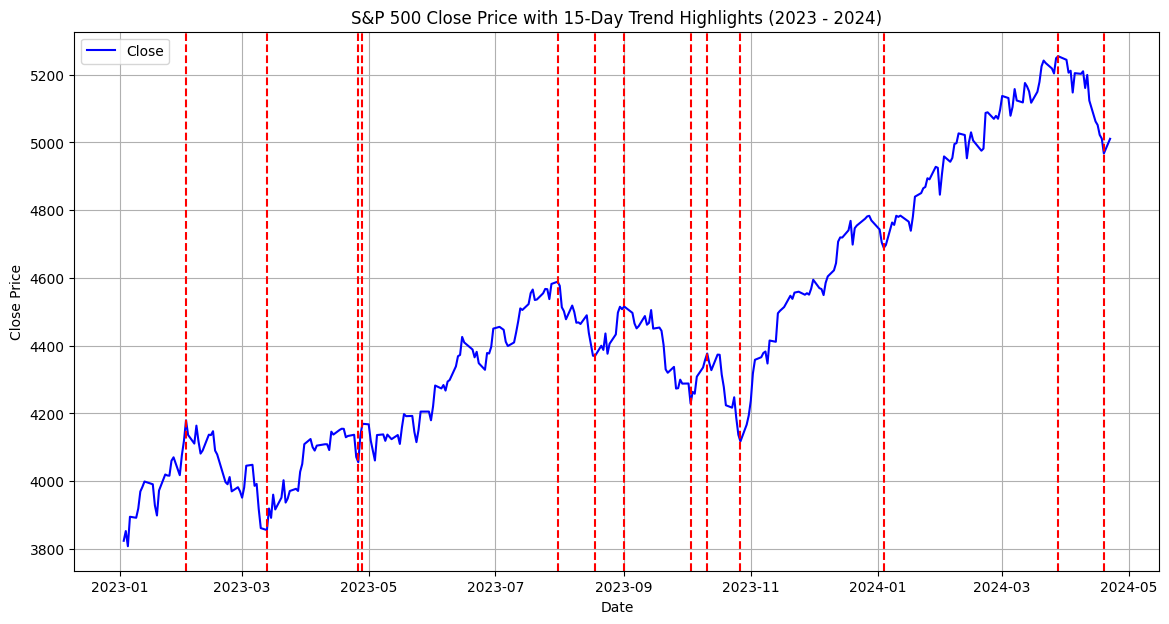

In [2]:
import matplotlib.pyplot as plt

# Filter the DataFrame for dates between 2023 and 2024
sp500_subset = sp500.loc['2023':'2024']

# Plot the Close column
plt.figure(figsize=(14, 7))
plt.plot(sp500_subset.index, sp500_subset['Close'], label='Close', color='blue')

# Highlight dates when Trend_9 transitions from 0 to 1 or 1 to 0
for i in range(1, len(sp500_subset)):
    if sp500_subset['Trend_Reversal_25'].iloc[i] == 0:
        plt.axvline(x=sp500_subset.index[i], color='red', linestyle='--')

plt.title('S&P 500 Close Price with 15-Day Trend Highlights (2023 - 2024)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
pd.set_option('display.max_columns', None)
merged_data

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Past_Trend_2,Close_Ratio_5,Past_Trend_5,Close_Ratio_60,Past_Trend_60,Close_Ratio_250,Past_Trend_250,Close_Ratio_1000,Past_Trend_1000,Stochastic Oscillator,RSI,Trend_Reversal_5,Trend_Reversal_15,Trend_Reversal_25,Avg_Pos_Score,Avg_Neu_Score,Avg_Neg_Score
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,3.733160e+09,2447.889893,0.0,1.000634,2.0,1.007304,4.0,0.936187,24.0,0.914200,131.0,1.072879,524.0,48.235264,36.791648,1.0,40.0,45.0,0.073750,0.848000,0.078250
2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,3.858830e+09,2531.939941,1.0,0.987466,1.0,0.983931,3.0,0.915501,24.0,0.891926,130.0,1.046128,524.0,31.306158,30.747061,0.0,39.0,44.0,0.057667,0.906111,0.036222
2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,4.234140e+09,2549.689941,1.0,1.016878,1.0,1.014200,3.0,0.949020,25.0,0.922835,130.0,1.081807,525.0,64.251749,40.297452,4.0,38.0,43.0,0.069222,0.833000,0.097889
2019-01-07,2535.610107,2566.159912,2524.560059,2549.689941,4.133120e+09,2574.409912,1.0,1.003493,2.0,1.016104,4.0,0.957651,26.0,0.929573,130.0,1.089132,526.0,79.791797,45.654805,3.0,37.0,42.0,0.056111,0.815444,0.128556
2019-01-08,2568.110107,2579.820068,2547.560059,2574.409912,4.120060e+09,2584.959961,1.0,1.004824,2.0,1.020461,4.0,0.968216,27.0,0.938827,130.0,1.099431,526.0,95.442114,52.592657,2.0,36.0,41.0,0.040000,0.874100,0.085900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-12,5171.509766,5175.029785,5107.939941,5123.410156,3.963220e+09,5061.819824,0.0,0.992671,1.0,0.989251,2.0,1.010379,34.0,1.121227,138.0,1.244487,532.0,9.859282,37.114073,5.0,5.0,5.0,0.122100,0.804000,0.074000
2024-04-15,5149.669922,5168.430176,5052.470215,5061.819824,3.950210e+09,5051.410156,0.0,0.993953,0.0,0.982693,2.0,0.997313,33.0,1.106866,137.0,1.228850,532.0,4.402305,33.554188,4.0,4.0,4.0,0.090900,0.741500,0.167700
2024-04-16,5064.589844,5079.839844,5039.830078,5051.410156,4.006200e+09,5022.209961,0.0,0.998971,0.0,0.986745,1.0,0.994570,32.0,1.103724,136.0,1.225664,531.0,5.146243,33.853278,3.0,3.0,3.0,0.088500,0.815500,0.095900


In [4]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [5]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

baseline_p = ["Open", "Close", "High", "Low", "Volume"]
moving_averages_p = ["Close_Ratio_2", "Close_Ratio_5", "Close_Ratio_60", "Close_Ratio_250", "Close_Ratio_1000"]
past_trends_p = ["Past_Trend_2", "Past_Trend_5", "Past_Trend_60", "Past_Trend_250", "Past_Trend_1000"]
oscillator_p = ["Stochastic Oscillator", "RSI"]
sentiment_p = ["Avg_Pos_Score", "Avg_Neu_Score", "Avg_Neg_Score"]

In [200]:
def backtest(data, model, predictors, start=300, step=80):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

model = RandomForestClassifier(n_estimators=900, min_samples_split=200, random_state=1)

In [201]:
predictions = backtest(merged_data, model, moving_averages_p+oscillator_p+sentiment_p)

pres = precision_score(predictions["Target"], predictions["Predictions"])
recall = recall_score(predictions["Target"], predictions["Predictions"])
f1 = f1_score(predictions["Target"], predictions["Predictions"])

print(f"{pres}\n{recall}\n{f1}")

0.5339912280701754
0.8903107861060329
0.6675805346127485


In [9]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1.0    0.529526
0.0    0.470474
Name: count, dtype: float64

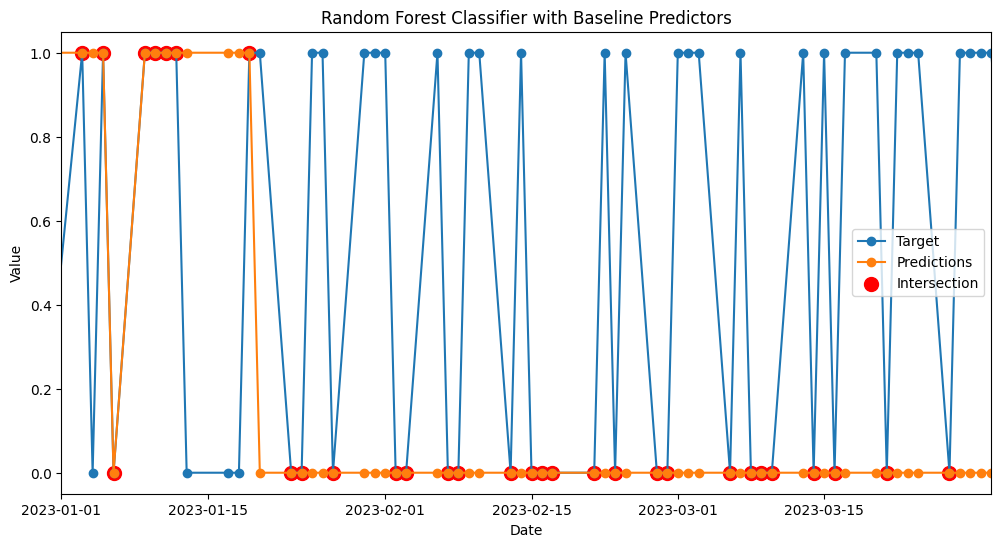

In [10]:
import matplotlib.pyplot as plt

# Assuming "Date" is the index column in your predictions DataFrame
predictions.index = pd.to_datetime(predictions.index)  # Convert the index to datetime if it's not already

# Filter the data for the year 2023
predictions_2023 = predictions[predictions.index.year == 2023]

# Plotting the Target and Predictions columns against the Date index
plt.figure(figsize=(12, 6))
plt.plot(predictions.index, predictions["Target"], label="Target", marker='o')
plt.plot(predictions.index, predictions["Predictions"], label="Predictions", marker='o')

# Marking where the two columns intersect
intersection_points = predictions[predictions["Target"] == predictions["Predictions"]]
plt.scatter(intersection_points.index, intersection_points["Target"], color='red', label='Intersection', s=100, marker='o')

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Random Forest Classifier with Baseline Predictors")
plt.xlim(pd.Timestamp("2023-01-01"), pd.Timestamp("2023-3-31"))  # Limit x-axis to year 2023
plt.legend()
plt.show()

Epoch 1/10, Validation Loss: 0.6865545681544712
Epoch 2/10, Validation Loss: 0.636626592704228
Epoch 3/10, Validation Loss: 0.5323483858789716
Epoch 4/10, Validation Loss: 0.369364253112248
Epoch 5/10, Validation Loss: 0.2764196736471994
Epoch 6/10, Validation Loss: 0.27325399432863506
Epoch 7/10, Validation Loss: 0.2673749881131308
Epoch 8/10, Validation Loss: 0.26600659106458935
Epoch 9/10, Validation Loss: 0.26552160935742514
Epoch 10/10, Validation Loss: 0.2650515522275652
Highest probability of when y is equal to 0: 2022-10-21


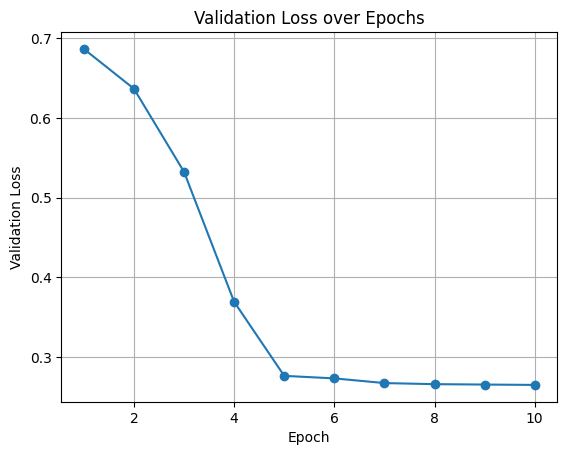

In [216]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Assuming 'merged_data' is your dataframe containing the stock data
data_tensor = torch.tensor(merged_data.values, dtype=torch.float32)

baseline_tensor = data_tensor[:, :5]
moving_averages_tensor = data_tensor[:, [7, 9, 11, 13, 15]]
past_trends_tensor = data_tensor[:, [8, 10, 12, 14, 16]]
oscillator_tensor = data_tensor[:, 17:19]
sentiment_tensor = data_tensor[:, 22:25]

from sklearn.preprocessing import StandardScaler

# Standardize baseline_tensor
scaler_baseline = StandardScaler()
baseline_tensor_standardized = scaler_baseline.fit_transform(baseline_tensor)

# Standardize moving_averages_tensor
scaler_moving_averages = StandardScaler()
moving_averages_tensor_standardized = scaler_moving_averages.fit_transform(moving_averages_tensor)

# Standardize past_trends_tensor
scaler_past_trends = StandardScaler()
past_trends_tensor_standardized = scaler_past_trends.fit_transform(past_trends_tensor)

# Standardize oscillator_tensor
scaler_oscillator = StandardScaler()
oscillator_tensor_standardized = scaler_oscillator.fit_transform(oscillator_tensor)

# Standardize sentiment_tensor
scaler_sentiment = StandardScaler()
sentiment_tensor_standardized = scaler_sentiment.fit_transform(sentiment_tensor)

baseline_tensor_standardized = torch.tensor(baseline_tensor_standardized, dtype=torch.float32)
moving_averages_tensor_standardized = torch.tensor(moving_averages_tensor_standardized, dtype=torch.float32)
past_trends_tensor_standardized = torch.tensor(past_trends_tensor_standardized, dtype=torch.float32)
oscillator_tensor_standardized = torch.tensor(oscillator_tensor_standardized, dtype=torch.float32)
sentiment_tensor_standardized = torch.tensor(sentiment_tensor_standardized, dtype=torch.float32)

# Split the data into input features (X) and target variable (y)
X = torch.cat((moving_averages_tensor_standardized, past_trends_tensor_standardized, sentiment_tensor_standardized), dim=1)
y = data_tensor[:, 20]   # Target

# Modify the target labels to indicate whether the next y value is 0
y_next_is_zero = torch.cat((y[1:], torch.tensor([0.0]))) == 0

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_next_is_zero, test_size=0.3, random_state=1)

# Convert the data into PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, batch_size=None):
        if x.dim() < 3:
            x = x.unsqueeze(0)  # Add batch dimension if input is a single sequence
            batch_size = 1
        else:
            batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define hyperparameters
input_size = X_train.shape[1]
hidden_size = 256
num_layers = 3

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# Define hyperparameters
num_epochs = 10

# Define empty lists to store epoch numbers and validation losses
epoch_numbers = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_dataloader:
            outputs = model(inputs.unsqueeze(1))
            val_loss += criterion(outputs.squeeze(), labels.float()).item()

        val_loss /= len(val_dataloader)
        epoch_numbers.append(epoch+1)
        validation_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}")

model.eval()
with torch.no_grad():
    probabilities = []
    for inputs, _ in val_dataloader:  # Using val_dataloader for demonstration
        outputs = model(inputs.unsqueeze(1))
        probabilities.extend(torch.sigmoid(outputs.squeeze()).tolist())

# Associate each predicted probability with its corresponding date
merged_data = merged_data.reset_index()
predicted_dates = merged_data['Date'].iloc[-len(probabilities):].tolist()
merged_data.set_index('Date', inplace=True)

#for date, prob in zip(predicted_dates, probabilities):
 #   print(f"Date: {date}, Probability of y=0: {prob}")

# Find the date with the highest predicted probability of y being 0
next_date_y_is_zero = predicted_dates[probabilities.index(max(probabilities))]
print(f"Highest probability of when y is equal to 0: {next_date_y_is_zero}")

# Plot the validation loss
plt.figure()
plt.plot(epoch_numbers, validation_losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.grid(True)
plt.show()

In [14]:
num_rows_with_zero = (merged_data['Trend_Reversal_15'] == 0).sum()
total_rows = merged_data.shape[0]
print(num_rows_with_zero)

percentage_zero_rows = (num_rows_with_zero / total_rows) * 100
print(f"Percentage of rows with values equal to 0: {percentage_zero_rows:.2f}%")

94
Percentage of rows with values equal to 0: 7.05%


Average deviation from a row where Trend_Reversal_15 is 0 for top 10 days: 4.0
Average deviation from a row where Trend_Reversal_15 is 0 for top 25 days: 6.2
Average deviation from a row where Trend_Reversal_15 is 0 for top 50 days: 6.94
Average deviation from a row where Trend_Reversal_15 is 0 for top 75 days: 6.973333333333334


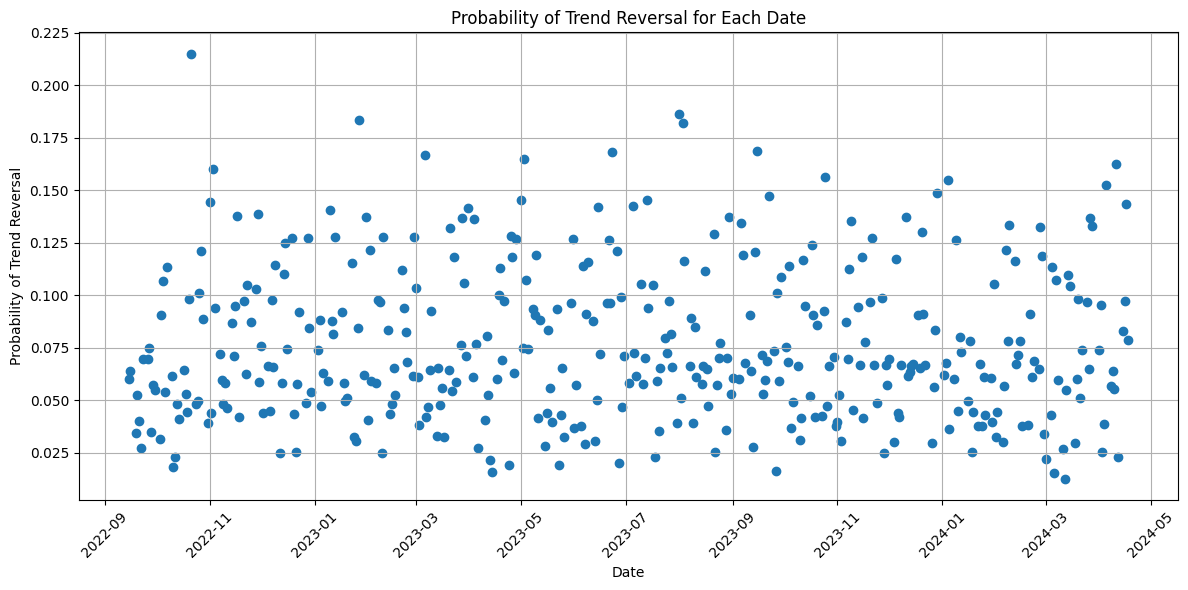

In [220]:
# Sort the predicted dates and probabilities in descending order of probabilities
sorted_predictions = sorted(zip(predicted_dates, probabilities), key=lambda x: x[1], reverse=True)

num_days_list = [10, 25, 50, 75]
for num_days in num_days_list:
    # Take the top n dates
    top_dates = [date for date, _ in sorted_predictions[:num_days]]

    # Find the total sum of days apart from a row where Trend_Reversal_15 is 0
    total_days_apart = 0
    for date in top_dates:
        date = pd.to_datetime(date, format='%Y-%m-%d')
        # Find the corresponding row in merged_data
        row = merged_data.loc[date.strftime('%Y-%m-%d')]

        merged_data = merged_data.reset_index()

        # Find the nearest row where Trend_Reversal_15 is 0
        nearest_zero_row = merged_data.loc[merged_data['Trend_Reversal_15'] == 0, 'Date'].apply(lambda x: abs((date - pd.to_datetime(x)).days)).idxmin()
        nearest_zero_date = merged_data.loc[nearest_zero_row, 'Date']

        merged_data.set_index('Date', inplace=True)

        # Calculate the number of days apart and add it to the total
        days_apart = abs((pd.to_datetime(row.name) - pd.to_datetime(nearest_zero_date)).days)
        total_days_apart += days_apart

    print(f"Average deviation from a row where Trend_Reversal_15 is 0 for top {num_days} days: {total_days_apart / num_days}")

# Unzip sorted predictions into separate lists
sorted_dates, sorted_probabilities = zip(*sorted_predictions)

# Convert dates to datetime objects
sorted_dates = [pd.to_datetime(date, format='%Y-%m-%d') for date in sorted_dates]

plt.figure(figsize=(12, 6))
plt.scatter(sorted_dates, sorted_probabilities, marker='o')
plt.xlabel('Date')
plt.ylabel('Probability of Trend Reversal')
plt.title('Probability of Trend Reversal for Each Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [212]:
pd.set_option('display.max_rows', 60)
merged_data

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Past_Trend_2,Close_Ratio_5,Past_Trend_5,Close_Ratio_60,Past_Trend_60,Close_Ratio_250,Past_Trend_250,Close_Ratio_1000,Past_Trend_1000,Stochastic Oscillator,RSI,Trend_Reversal_5,Trend_Reversal_15,Trend_Reversal_25,Avg_Pos_Score,Avg_Neu_Score,Avg_Neg_Score
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,3.733160e+09,2447.889893,0.0,1.000634,2.0,1.007304,4.0,0.936187,24.0,0.914200,131.0,1.072879,524.0,48.235264,36.791648,1.0,40.0,45.0,0.073750,0.848000,0.078250
2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,3.858830e+09,2531.939941,1.0,0.987466,1.0,0.983931,3.0,0.915501,24.0,0.891926,130.0,1.046128,524.0,31.306158,30.747061,0.0,39.0,44.0,0.057667,0.906111,0.036222
2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,4.234140e+09,2549.689941,1.0,1.016878,1.0,1.014200,3.0,0.949020,25.0,0.922835,130.0,1.081807,525.0,64.251749,40.297452,4.0,38.0,43.0,0.069222,0.833000,0.097889
2019-01-07,2535.610107,2566.159912,2524.560059,2549.689941,4.133120e+09,2574.409912,1.0,1.003493,2.0,1.016104,4.0,0.957651,26.0,0.929573,130.0,1.089132,526.0,79.791797,45.654805,3.0,37.0,42.0,0.056111,0.815444,0.128556
2019-01-08,2568.110107,2579.820068,2547.560059,2574.409912,4.120060e+09,2584.959961,1.0,1.004824,2.0,1.020461,4.0,0.968216,27.0,0.938827,130.0,1.099431,526.0,95.442114,52.592657,2.0,36.0,41.0,0.040000,0.874100,0.085900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-12,5171.509766,5175.029785,5107.939941,5123.410156,3.963220e+09,5061.819824,0.0,0.992671,1.0,0.989251,2.0,1.010379,34.0,1.121227,138.0,1.244487,532.0,9.859282,37.114073,5.0,5.0,5.0,0.122100,0.804000,0.074000
2024-04-15,5149.669922,5168.430176,5052.470215,5061.819824,3.950210e+09,5051.410156,0.0,0.993953,0.0,0.982693,2.0,0.997313,33.0,1.106866,137.0,1.228850,532.0,4.402305,33.554188,4.0,4.0,4.0,0.090900,0.741500,0.167700
2024-04-16,5064.589844,5079.839844,5039.830078,5051.410156,4.006200e+09,5022.209961,0.0,0.998971,0.0,0.986745,1.0,0.994570,32.0,1.103724,136.0,1.225664,531.0,5.146243,33.853278,3.0,3.0,3.0,0.088500,0.815500,0.095900
